In [6]:
!pip install pulp sktime

# Statistics & Machine Learning in Automation and Operations

Machne learning is a field of AI that focuses on building systems that learn from data.
The goal is to use data to understand the underlying patterns and make predictions.

In general we can use:

- in a supervised way, where we somehow "know" an answer to a particular question (on trainining questions), for example: we know which engines broke based on their behaviour or we know which images show us defects
- in an unsupervised way, where we have data but we don't nesseesarely know the answers. What we ask the AI to do is to somehow divide the data into meaningfull parterns or try to compress it i.e. find features that describe best our data. For example the model can show how a "healthy machine" behaves on a factory floor and will enable us to distinguish it from a faulty ones
- reinforcement learning is a learning where we give "points/ awards" for a good results not nessesarely focusing on particular behaviours or singular decisions. For example we may train a robot to walk by awarding how far he could get without falling.

# Time series forecasting

Time series forecasting is a type of supervised learning where we use historical data to predict future values.





(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

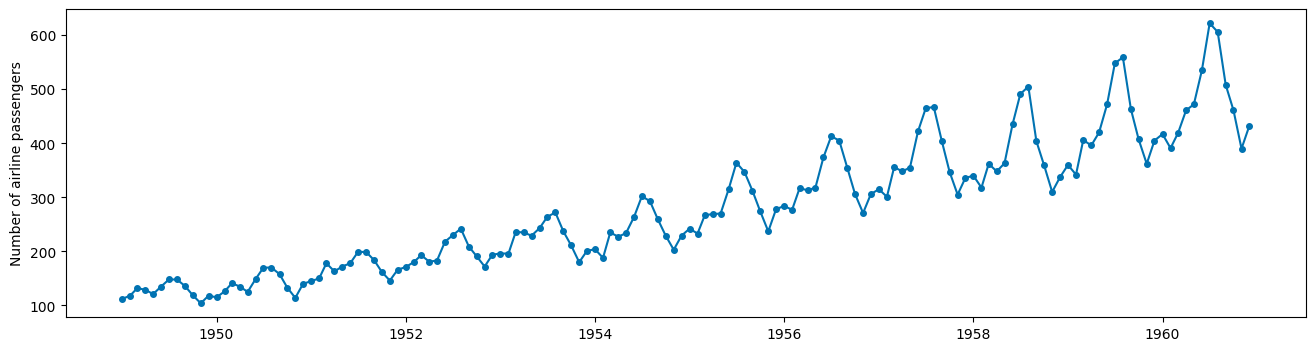

In [7]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series

import numpy as np
y = load_airline() #we load an example dataset showing the monthly number of passengers on an airline

# plotting for visualization
plot_series(y)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

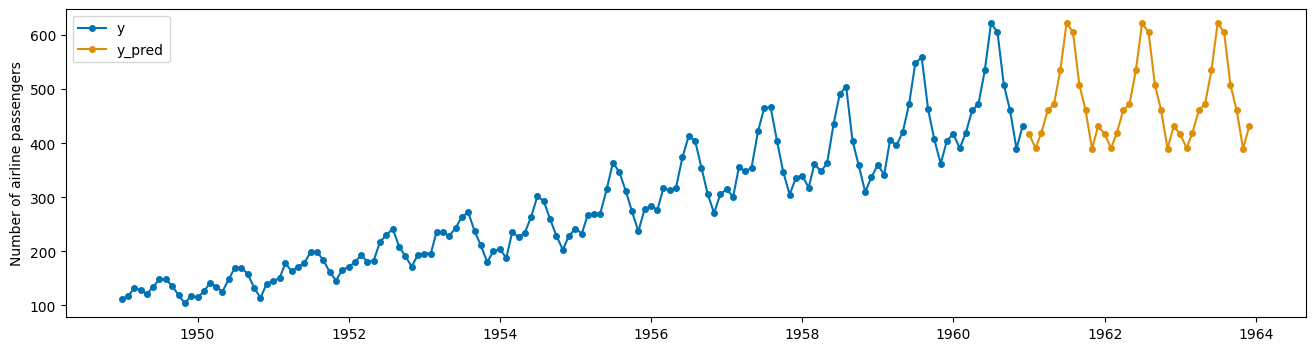

In [8]:
# step 2: specifying forecasting horizon
fh = np.arange(1, 37)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)



# step 4: fitting the forecaster
forecaster.fit(y)

# step 5: querying predictions
y_pred = forecaster.predict(fh)
# optional: plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1p9_08fj/44d1rqc7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1p9_08fj/4p1l5dzn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48732', 'data', 'file=/tmp/tmp1p9_08fj/44d1rqc7.json', 'init=/tmp/tmp1p9_08fj/4p1l5dzn.json', 'output', 'file=/tmp/tmp1p9_08fj/prophet_modelxj_n02qr/prophet_model-20250421135658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:56:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:56:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

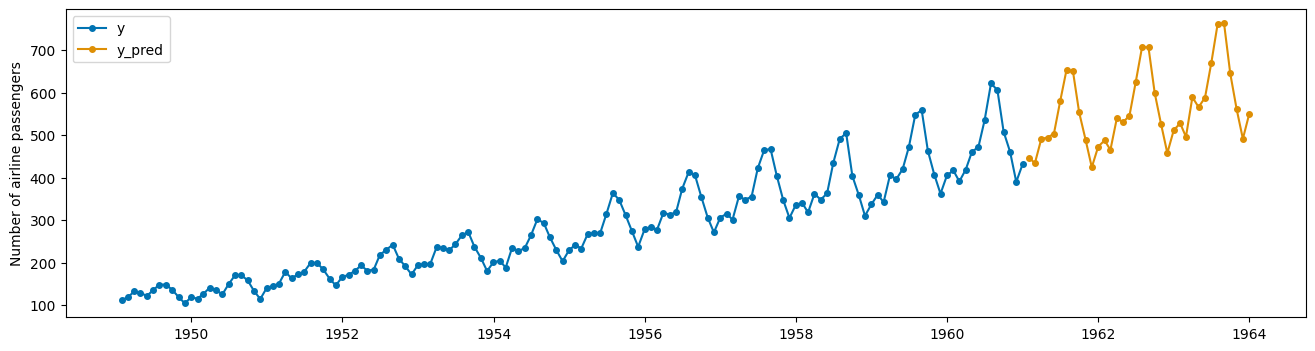

In [9]:
!pip install prophet
from sktime.datasets import load_airline
from sktime.forecasting.fbprophet import Prophet
# Prophet requires to have data with a pandas.DatetimeIndex
ym = load_airline().to_timestamp(freq='M')
forecaster = Prophet(
    seasonality_mode='multiplicative',
    n_changepoints=int(len(y) / 12),
    add_country_holidays={'country_name': 'Germany'},
    yearly_seasonality=True)
forecaster.fit(ym)
Prophet(...)
y_predm = forecaster.predict(fh)
plot_series(ym, y_predm, labels=["y", "y_pred"])

# Excercise:
 download the prices of : eggs, chicken, beef, milk from https://fred.stlouisfed.org/categories/32217, other if you want

estimate what is the best blend of products for the cat food problem for june of this year, is it the same for september?


Steps:
- load the data
- plot the data
- try to find a model that forecasts the data well
- make a prediction for june of this year
- make a prediction for september of this year
- use the predictions to put the price of the blend of products on the market
- use a typical linear programming model to find the best blend of products that minimizes the cost of the blend

In [38]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.optimize import linprog
from pandas.tseries.offsets import MonthEnd

# --- 1. Veriyi Yükle ---
data = pd.DataFrame()
for product in ['eggs', 'chicken', 'beef', 'milk']:
    df = pd.read_csv(f'{product}.csv')
    df['observation_date'] = pd.to_datetime(df['observation_date'])
    df.set_index('observation_date', inplace=True)
    df.rename(columns={df.columns[0]: product}, inplace=True)
    if data.empty:
        data = df
    else:
        data = data.join(df, how='outer')

# --- 2. Tahmin Fonksiyonu ---
def forecast_prices(series, steps):
    model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=steps)
    return forecast

# --- 3. Haziran ve Eylül için steps hesapla ---
last_date = data.index[-1]
target_june = pd.Timestamp("2025-06-30") + MonthEnd(0)
target_sept = pd.Timestamp("2025-09-30") + MonthEnd(0)
steps_june = (target_june.year - last_date.year) * 12 + (target_june.month - last_date.month)
steps_sept = (target_sept.year - last_date.year) * 12 + (target_sept.month - last_date.month)

# --- 4. Tahminleri Al ---
forecast_june = {col: forecast_prices(data[col], steps_june).iloc[-1] for col in data.columns}
forecast_sept = {col: forecast_prices(data[col], steps_sept).iloc[-1] for col in data.columns}
print("📅 June Forecast:", forecast_june)
print("📅 September Forecast:", forecast_sept)

# --- 5. Linear Programming (besin değerleri: protein ve yağ) ---
# 100g başına değerler (örnek): [protein, yağ]
nutrition_matrix = [
    [13, 10],   # eggs
    [20, 5],    # chicken
    [25, 15],   # beef
    [3, 3]      # milk
]
nutrition_requirements = [50, 30]  # min protein, min yağ

# --- 6. Maliyet vektörleri ---
costs_june = [forecast_june[k] for k in ['eggs', 'chicken', 'beef', 'milk']]
costs_sept = [forecast_sept[k] for k in ['eggs', 'chicken', 'beef', 'milk']]

# --- 7. LP problemi çöz ---
def solve_lp(costs, title):
    result = linprog(
        c=costs,
        A_ub=[[-x for x in col] for col in zip(*nutrition_matrix)],
        b_ub=[-x for x in nutrition_requirements],
        bounds=(0, None),
        method='highs'
    )
    print(f"\n📊 Optimal blend for {title}:")
    if result.success:
        for i, product in enumerate(['eggs', 'chicken', 'beef', 'milk']):
            print(f"  {product.title()}: {result.x[i]:.2f} kg")
        print(f"💰 Total cost: ${result.fun:.2f}")
    else:
        print("❌ LP problem could not be solved. Check nutrition matrix and requirements.")

# --- 8. Sonuçları yazdır ---
solve_lp(costs_june, "June")
solve_lp(costs_sept, "September")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

📅 June Forecast: {'eggs': np.float64(6.571416811938736), 'chicken': np.float64(4.2455363862851865), 'beef': np.float64(5.960650985204926), 'milk': np.float64(4.0858807990407024)}
📅 September Forecast: {'eggs': np.float64(6.919318102609104), 'chicken': np.float64(4.259794151225513), 'beef': np.float64(5.973595640174878), 'milk': np.float64(4.131870530494501)}

📊 Optimal blend for June:
  Eggs: 0.00 kg
  Chicken: 0.00 kg
  Beef: 2.00 kg
  Milk: 0.00 kg
💰 Total cost: $11.92

📊 Optimal blend for September:
  Eggs: 0.00 kg
  Chicken: 0.00 kg
  Beef: 2.00 kg
  Milk: 0.00 kg
💰 Total cost: $11.95


# Regression models

Regression models are a type of supervised learning where we estimate a function that maps inputs to outputs.





In [10]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
df_failures = pd.read_csv('data/sensor_readings_timeseries.csv')

# Display the first few rows to verify loading
print(df_failures.head())

# Display basic information about the DataFrame
print(df_failures.info())

# Display descriptive statistics
df_failures.describe()

   instance_id  machine_id department failure_type   time  sensor_temp  \
0            1           4    Welding   Mechanical    0.0    62.887414   
1            1           4    Welding   Mechanical  100.0    67.749149   
2            1           4    Welding   Mechanical  200.0    63.446070   
3            1           4    Welding   Mechanical  300.0    65.999297   
4            1           4    Welding   Mechanical  400.0    61.228597   

   sensor_vib           rul  near_failure  
0    0.174999  10308.096762             0  
1    0.149790  10208.096762             0  
2    0.202742  10108.096762             0  
3    0.213483  10008.096762             0  
4    0.221188   9908.096762             0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190339 entries, 0 to 190338
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   instance_id   190339 non-null  int64  
 1   machine_id    190339 non-null  int64  
 2   

,instance_id,machine_id,time,sensor_temp,sensor_vib,rul,near_failure
count,190339.000000,190339.000000,190339.000000,190339.000000,190339.000000,190339.000000,190339.000000
mean,3953.601327,2.082763,5472.699343,61.548008,1.295366,5426.586009,0.084061
std,2302.519752,1.225247,8678.079374,11.082120,2.353995,8675.590773,0.277479
min,1.000000,1.000000,0.000000,41.868645,0.010000,0.000000,0.000000
25%,1945.000000,1.000000,600.000000,52.771829,0.115480,566.584477,0.000000
50%,3955.000000,1.000000,2000.000000,57.975624,0.158956,1928.113178,0.000000
75%,5947.000000,3.000000,6200.000000,68.487811,1.128911,6125.310478,0.000000
max,8000.000000,4.000000,76285.247981,101.395336,9.781395,76285.247981,1.000000


In [11]:
try:
    # Try running the generation scripts
    !python generate_four_machines.py
    !python generate_sensor_timeseries.py
except:
    # If generation fails, download the data file
    import os
    if not os.path.exists('data'):
        os.makedirs('data')

    !curl -L https://raw.githubusercontent.com/AdoHaha/automation_robotics_lab/master/data/sensor_readings_timeseries.csv -o data/sensor_readings_timeseries.csv


python3: can't open file '/content/generate_four_machines.py': [Errno 2] No such file or directory
python3: can't open file '/content/generate_sensor_timeseries.py': [Errno 2] No such file or directory


In [12]:
import numpy as np
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df_failures[['machine_id', 'time', 'sensor_temp', 'sensor_vib']]
y = df_failures['near_failure']
# Get unique instance IDs
unique_instances = df_failures['instance_id'].unique()

# Split the instance IDs into training and testing sets (70% train, 30% test)
train_instances, test_instances = train_test_split(
    unique_instances,
    test_size=0.3,
    random_state=42
)

# Create train and test sets based on instance IDs
X_train = X[df_failures['instance_id'].isin(train_instances)]
y_train = y[df_failures['instance_id'].isin(train_instances)]

X_test = X[df_failures['instance_id'].isin(test_instances)]
y_test = y[df_failures['instance_id'].isin(test_instances)]

print(f"Training set size: {len(X_train)} samples from {len(train_instances)} instances")
print(f"Testing set size: {len(X_test)} samples from {len(test_instances)} instances")


Training set size: 132641 samples from 5600 instances
Testing set size: 57698 samples from 2400 instances


In [13]:
from sklearn.ensemble import RandomForestClassifier
# Import additional classifiers for comparison
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [14]:



# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(
    n_estimators=10,  # Number of trees in the forest
    random_state=42,  # For reproducibility
    class_weight='balanced',  # Address class imbalance
    max_depth=5
)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)




RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=10,
                       random_state=42)

In [15]:
# calculate the accuracy of the model
from sklearn.metrics import accuracy_score

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.90


In [16]:
from sklearn.ensemble import GradientBoostingClassifier
gradient_boosting_classifier = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Train the classifier on the training data
gradient_boosting_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gradient_boosting_classifier.predict(X_test)



# Excercise:  Try to get the accuracy to over 98% by changing the model or the parameters

In [39]:
# Initialize the Gradient Boosting classifier with adjusted parameters
gradient_boosting_classifier = GradientBoostingClassifier(
    n_estimators=500,  # Increased number of trees
    learning_rate=0.05,  # Reduced learning rate for finer tuning
    max_depth=5,  # Increased tree depth for more complex relationships
    subsample=0.8,  # Use a fraction of samples for training each tree
    min_samples_split=5,  # Minimum number of samples required to split an internal node
    min_samples_leaf=2,  # Minimum number of samples required to be at a leaf node
    random_state=42  # For reproducibility
)

# Train the classifier on the training data
gradient_boosting_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gradient_boosting_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.98


# Excercise:

- A reading for a machine of type 4 was recorded when machine had 110.0 workhours. Its sensor showed a temperature of 87.18 degrees Celsius and a vibration level of 5.96.
- A reading for a machine of type 1 was recorded when machine had 250.0 workhours. Its sensor showed a temperature of 76.05 degrees Celsius and a vibration level of 8.43.
- A reading for a machine of type 3 was recorded when machine had 690.0 workhours. Its sensor showed a temperature of 57.36 degrees Celsius and a vibration level of 0.07.
- A reading for a machine of type 1 was recorded when machine had 20510.0 workhours. Its sensor showed a temperature of 53.30 degrees Celsius and a vibration level of 0.08.
- A reading for a machine of type 2 was recorded when machine had 270.0 workhours. Its sensor showed a temperature of 71.13 degrees Celsius and a vibration level of 0.22.
- A reading for a machine of type 4 was recorded when machine had 110.0 workhours. Its sensor showed a temperature of 67.56 degrees Celsius and a vibration level of 0.13.

You have two technicians available, that cost 600 PLN/hour. You have a budget of 1800 PLN. Each machine requires an hour to service. Which machine to service if machine of the type 1,2 failure cost you 3000 PLN, machine of the 3, 4 failure costs you 2500 PLN?

In [42]:
# prompt: Excercise:
# A reading for a machine of type 4 was recorded when machine had 110.0 workhours. Its sensor showed a temperature of 87.18 degrees Celsius and a vibration level of 5.96.
# A reading for a machine of type 1 was recorded when machine had 250.0 workhours. Its sensor showed a temperature of 76.05 degrees Celsius and a vibration level of 8.43.
# A reading for a machine of type 3 was recorded when machine had 690.0 workhours. Its sensor showed a temperature of 57.36 degrees Celsius and a vibration level of 0.07.
# A reading for a machine of type 1 was recorded when machine had 20510.0 workhours. Its sensor showed a temperature of 53.30 degrees Celsius and a vibration level of 0.08.
# A reading for a machine of type 2 was recorded when machine had 270.0 workhours. Its sensor showed a temperature of 71.13 degrees Celsius and a vibration level of 0.22.
# A reading for a machine of type 4 was recorded when machine had 110.0 workhours. Its sensor showed a temperature of 67.56 degrees Celsius and a vibration level of 0.13.
# You have two technicians available, that cost 600 PLN/hour. You have a budget of 1800 PLN. Each machine requires an hour to service. Which machine to service if machine of the type 1,2 failure cost you 3000 PLN, machine of the 3, 4 failure costs you 2500 PLN?

import pandas as pd
from scipy.optimize import linprog

# Data for machines
data = {
    'machine_type': [4, 1, 3, 1, 2, 4],
    'workhours': [110.0, 250.0, 690.0, 20510.0, 270.0, 110.0],
    'temperature': [87.18, 76.05, 57.36, 53.30, 71.13, 67.56],
    'vibration': [5.96, 8.43, 0.07, 0.08, 0.22, 0.13],
    'failure_cost': [2500, 3000, 2500, 3000, 3000, 2500]
}
df = pd.DataFrame(data)

# Technician cost and budget
technician_cost_per_hour = 600
budget = 1800
max_service_hours = budget / technician_cost_per_hour

# Objective function: Maximize total avoided failure cost
# c = -failure_cost (minimize negative to maximize positive)
df['weighted_cost'] = df['failure_cost'] * (df['temperature'] + df['vibration'])
c = -df['weighted_cost'].values

# Constraints:
# 1. Total service hours <= Max service hours
A_eq = [[1] * len(df)]
b_eq = [max_service_hours]

# 2. Each machine can be serviced at most once
bounds = [(0, 1)] * len(df)

# Solve the linear program
result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

# Print results
if result.success:
  print("Optimal solution found:")
  print(f"Total avoided failure cost: {-result.fun:.2f} PLN")
  print("Machines to service:")
  for i in range(len(df)):
    if result.x[i] > 0.5:  # Consider a service if probability >0.5
      print(f"  Machine type {df['machine_type'][i]}, workhours: {df['workhours'][i]}, temperature: {df['temperature'][i]}, vibration: {df['vibration'][i]}")
else:
  print(f"Optimization failed: {result.message}")


Optimal solution found:
Total avoided failure cost: 700340.00 PLN
Machines to service:
  Machine type 4, workhours: 110.0, temperature: 87.18, vibration: 5.96
  Machine type 1, workhours: 250.0, temperature: 76.05, vibration: 8.43
  Machine type 2, workhours: 270.0, temperature: 71.13, vibration: 0.22
